In [1]:
# import stuff
import os
# os.sys.path.append("C:\\Users\\markp\\repos\\MightyMorphingPhotonRangers")
os.sys.path.append("C:\\Users\\markp\\repos\\nmftools")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
import sklearn as sk
import SingleCellSimNMF as scnmf
import pickle
import nmftools
from nmftools import cv

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df[(df['ImagingRegion']=='CA1' )|(df['ImagingRegion']=='')]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [89]:
df[df["MouseName"]=="4343702.1"].iloc[4:]

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanmat,s2pfolder
3655,4343702.1,20_03_2020,3,TwoTower_foraging,85,1,CA1,2020-03-20,D:\VR_Data\TwoTower\4343702.1\20_03_2020\TwoTo...,None,None
3676,4343702.1,21_03_2020,2,TwoTower_foraging,67,1,CA1,2020-03-21,D:\VR_Data\TwoTower\4343702.1\21_03_2020\TwoTo...,None,None
3696,4343702.1,22_03_2020,3,TwoTower_foraging,82,1,CA1,2020-03-22,D:\VR_Data\TwoTower\4343702.1\22_03_2020\TwoTo...,None,None


In [71]:
mouse = '4343706'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse.iloc[-2]

with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
S_trial_mat[np.isnan(S_trial_mat)]=0


morphs = trial_info['morphs']+trial_info['wallJitter']
msort = np.argsort(trial_info['morphs']+trial_info['wallJitter'])
S_trial_mat=S_trial_mat[msort,:,:]
S_tm_norm = S_trial_mat/np.linalg.norm(S_trial_mat,ord=2,axis=1)[:,np.newaxis,:]
S_sim =  np.transpose(np.matmul(np.transpose(S_tm_norm,axes=(2,0,1)),np.transpose(S_tm_norm,axes=(2,1,0))),axes=(1,2,0))
S_sim[np.isnan(S_sim)]=0
    
results = nmftools.ensemble.fit_ensemble(S_sim.reshape(-1,S_sim.shape[-1]).T,[1,2,3,4,5],n_replicates=3)



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.88s/it]


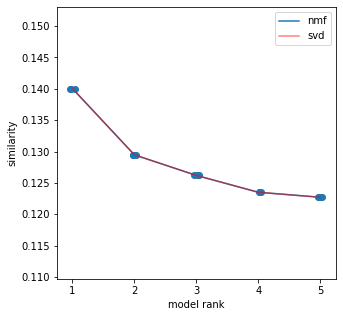

In [72]:
f,ax = plt.subplots(figsize=[5,5])
nmftools.plot_rmse(results,ax=ax)
# ax.set_ylim([np.amin()])
f.savefig("D:\\Morph_Results\\figures\\NMF\\%s_%s_%i_rmse.pdf" % (sess["MouseName"],sess["DateFolder"],sess['SessionNumber']),format="pdf")

(1403, 3) (3, 3600)
(60, 60, 1403)


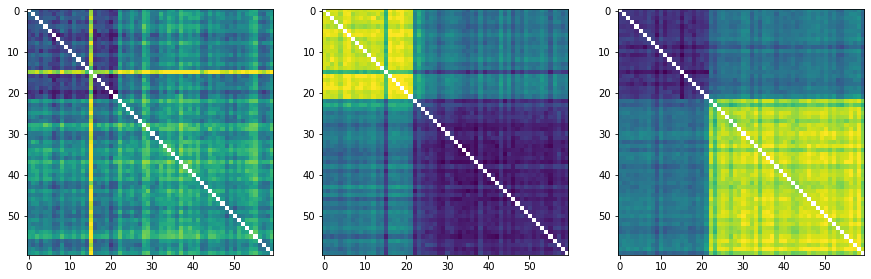

In [73]:
R=3
W,H=results[R]['factors'][0]
print(W.shape,H.shape)
f,ax = plt.subplots(1,R,figsize=[5*R,5])
for r in range(R):
    _H = H[r,:].reshape(S_sim.shape[0],S_sim.shape[0])
    _H[np.diag_indices_from(_H)]=np.nan
    ax[r].imshow(_H,vmax=np.percentile(_H[~np.isnan(_H)].ravel(),99))
f.savefig("D:\\Morph_Results\\figures\\NMF\\%s_%s_%i_factors.pdf" % (sess["MouseName"],sess["DateFolder"],sess['SessionNumber']),format="pdf")
print(S_sim.shape)

In [5]:
U, Vt, train_err, test_err = cv.cv_pca(S_sim.reshape(-1,S_sim.shape[-1]).T,2,nonneg=True)

In [6]:
print(Vt.shape)

(2, 3600)


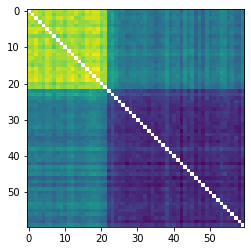

In [9]:
f,ax = plt.subplots()
fac = Vt[1,:].reshape(morphs.shape[0],morphs.shape[0])
fac[np.diag_indices_from(fac)]=np.nan
ax.imshow(fac)

In [11]:
results = nmftools.ensemble.fit_ensemble(S_sim.reshape(-1,S_sim.shape[-1]).T,[1,2,3,4,5],n_replicates=3)


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.57s/it]


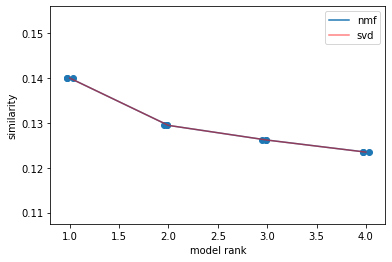

In [12]:
nmftools.plot_rmse(results)

(1403, 2) (2, 3600)


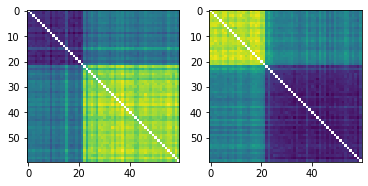

In [14]:
W,H=results[2]['factors'][0]
print(W.shape,H.shape)
f,ax = plt.subplots(1,2)
for n in range(2):
    _H = H[n,:].reshape(S_sim.shape[0],S_sim.shape[0])
    _H[np.diag_indices_from(_H)]=np.nan
    ax[n].imshow(_H)

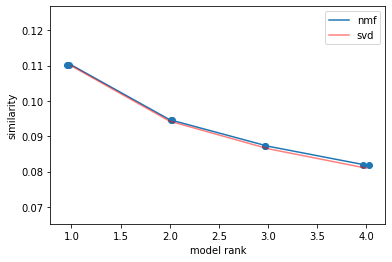

In [70]:
f,ax = plt.subplots()
test_err = [np.mean(d['test_err']) for k,d in results.items()]
train_err = [np.mean(d['train_err']) for k,d in results.items()]

ax.plot(np.arange(1,len(train_err)+1),train_err)
ax.plot(np.arange(1,len(train_err)+1),test_err)
ax.set_xlabel("Rank")
ax.set_ylabel("Reconstruction Error")

In [4]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sess = [5,5,5,3,5,2,4,4,4,4,4,4]
rare_mice,rare_fs = mice[:6],first_sess[:6]
freq_mice,freq_fs = mice[6:],first_sess[6:]
rare = [i<6 for i in range(len(mice))]
freq = [(1-r)>0 for r in rare]
print(rare,freq)

[True, True, True, True, True, True, False, False, False, False, False, False] [False, False, False, False, False, False, True, True, True, True, True, True]


In [122]:
SM=[]
for m,mouse in enumerate(rare_mice):
    print(mouse)
    df_mouse = df[df["MouseName"]==mouse]
    for ind in range(rare_fs[m],df_mouse.shape[0]):
        print(ind)
        sess = df_mouse.iloc[ind]
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0


        morphs = trial_info['morphs']+trial_info['wallJitter']
        morphbin = np.linspace(-.0,1.0,num=10)
        morphdig = np.digitize(morphs,morphbin)
        print(np.unique(morphdig))
        S_tm_bin = np.zeros([10,S_trial_mat.shape[1],S_trial_mat.shape[2]])
        for i in range(10):
            if (morphdig==i).sum()>0:
                S_tm_bin[i,:,:] = S_trial_mat[morphdig==i,:,:].mean(axis=0)
        S_tm_norm = S_tm_bin/np.linalg.norm(S_tm_bin,ord=2,axis=1,keepdims=True)


        S_sim =  np.transpose(np.matmul(np.transpose(S_tm_norm,axes=(2,0,1)),np.transpose(S_tm_norm,axes=(2,1,0))),axes=(1,2,0))
        S_sim[np.isnan(S_sim)]=0
        SM.append(S_sim)
SM = np.concatenate(SM,axis=-1)

4139265.3
5
[ 0  1  2  3  4  5  6  7  8  9 10]
6
[ 0  1  2  3  4  5  6  7  8  9 10]
7
[ 0  1  2  3  4  5  6  7  8  9 10]
8
[ 0  1  2  3  4  5  6  7  8  9 10]
9
[ 0  1  2  3  4  5  6  7  8  9 10]
4139265.4
5
[ 0  1  2  3  4  5  6  7  8  9 10]
6
[ 0  1  2  3  4  5  6  7  8  9 10]
7
[ 0  1  2  3  4  5  6  7  8  9 10]
8
[ 0  1  2  3  4  5  6  7  8  9 10]
9
[ 0  1  2  3  4  5  6  7  8  9 10]
10
[ 0  1  2  3  4  5  6  7  8  9 10]
4139265.5
5
[ 0  1  2  3  4  5  6  7  8  9 10]
6
[ 0  1  2  3  4  5  6  7  8  9 10]
7
[ 0  1  2  3  4  5  6  7  8  9 10]
8
[ 0  1  2  3  4  5  6  7  8  9 10]
9
[ 0  1  2  3  4  5  6  7  8  9 10]
4222168.1
3
[ 0  1  2  3  4  5  6  7  8  9 10]
4
[ 0  1  2  3  4  5  6  7  8  9 10]
5
[ 0  1  2  3  4  5  6  7  8  9 10]
6
[ 0  1  2  3  4  5  6  7  8  9 10]
4343703.1
5
[ 0  1  2  3  4  5  6  7  8  9 10]
4343706
2
[ 0  1  2  3  4  5  6  7  8  9 10]
3
[ 0  1  2  3  4  5  6  7  8  9 10]
4
[ 0  1  2  3  4  5  6  7  8  9 10]


In [123]:
rare_results = nmftools.ensemble.fit_ensemble_CV(SM.reshape(-1,SM.shape[-1]).T,[1,2,3,4,5,6,7],n_replicates=3)











  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

0
1
2












 14%|███████████▊                                                                       | 1/7 [09:31<57:06, 571.03s/it]

0
1
2












 29%|███████████████████████▋                                                           | 2/7 [21:13<50:52, 610.41s/it]

0
1
2












 43%|███████████████████████████████████▌                                               | 3/7 [33:25<43:07, 646.93s/it]

0
1
2












 57%|███████████████████████████████████████████████▍                                   | 4/7 [46:41<34:34, 691.55s/it]

0
1
2












 71%|█████████████████████████████████████████████████████████▊                       | 5/7 [1:01:53<25:15, 757.87s/it]

0
1
2












 86%|█████████████████████████████████████████████████████████████████████▍           | 6/7 [1:24:38<15:39, 939.99s/it]

0
1
2












100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:45:07<00:00, 901.06s/it]


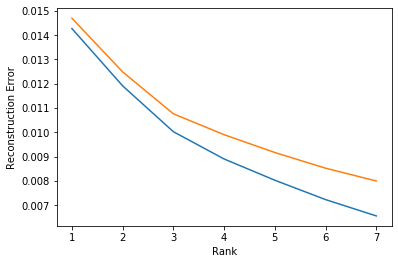

In [131]:
f,ax = plt.subplots()
test_err = [np.mean(d['test_err']) for k,d in rare_results.items()]
train_err = [np.mean(d['train_err']) for k,d in rare_results.items()]

ax.plot(np.arange(1,len(train_err)+1),train_err)
ax.plot(np.arange(1,len(train_err)+1),test_err)
ax.set_xlabel("Rank")
ax.set_ylabel("Reconstruction Error")
f.savefig("D:\\Morph_Results\\figures\\NMF\\rare_error.pdf",format="pdf")

In [11]:
rank = 2
W,H = rare_results[rank]['factors'][0]
print(W.shape,H.shape)
HH = H.reshape(rank,10,10)
f,ax = plt.subplots(1,3,figsize=[5,15])
for r in range(rank):
    _H = HH[r,:,:]
    _H[np.diag_indices_from(_H)]=1
#     f,ax = plt.subplots()
    ax[r].imshow(_H,vmax=np.percentile(_H,70))
f.savefig("D:\\Morph_Results\\figures\\NMF\\rare_factors.pdf",format="pdf")

NameError: name 'rare_results' is not defined

In [5]:
SM=[]
for m,mouse in enumerate(freq_mice):
    print(mouse)
    df_mouse = df[df["MouseName"]==mouse]
    for ind in range(freq_fs[m],df_mouse.shape[0]):
        print(ind)
        sess = df_mouse.iloc[ind]
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0


        morphs = trial_info['morphs']+trial_info['wallJitter']
        morphbin = np.linspace(-.05,1.11,num=11)
        morphdig = np.digitize(morphs,morphbin)
        S_tm_bin = np.zeros([10,S_trial_mat.shape[1],S_trial_mat.shape[2]])
        for i in range(10):
            if (morphdig==i).sum()>0:
                S_tm_bin[i,:,:] = S_trial_mat[morphdig==i,:,:].mean(axis=0)
        S_tm_norm = S_tm_bin/np.linalg.norm(S_tm_bin,ord=2,axis=1,keepdims=True)


        S_sim =  np.transpose(np.matmul(np.transpose(S_tm_norm,axes=(2,0,1)),np.transpose(S_tm_norm,axes=(2,1,0))),axes=(1,2,0))
        S_sim[np.isnan(S_sim)]=0
        SM.append(S_sim)
SM = np.concatenate(SM,axis=-1)


4222153.1
4
5
6
4222153.2
4
5
6
7
4222153.3
4
4222174.1
4
5
6
7
8
4222154.1
4
5
6
7
8
4343702.1
4
5
6


In [6]:
freq_results = nmftools.ensemble.fit_ensemble_CV(SM.reshape(-1,SM.shape[-1]).T,[1,2,3,4,5,6,7],n_replicates=3)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

0
1
2


 14%|███████████▊                                                                       | 1/7 [06:44<40:25, 404.31s/it]

0
1
2


 29%|███████████████████████▋                                                           | 2/7 [15:20<36:28, 437.77s/it]

0
1
2


 43%|███████████████████████████████████▌                                               | 3/7 [24:27<31:22, 470.54s/it]

0
1
2


 57%|███████████████████████████████████████████████▍                                   | 4/7 [34:19<25:21, 507.05s/it]

0
1
2


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [45:04<18:16, 548.40s/it]

0
1
2


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [57:03<09:59, 599.73s/it]

0
1
2


100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:12:28<00:00, 621.14s/it]


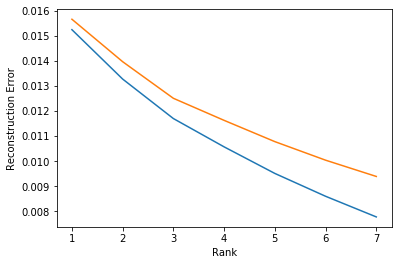

In [7]:
f,ax = plt.subplots()
test_err = [np.mean(d['test_err']) for k,d in freq_results.items()]
train_err = [np.mean(d['train_err']) for k,d in freq_results.items()]

ax.plot(np.arange(1,len(train_err)+1),train_err)
ax.plot(np.arange(1,len(train_err)+1),test_err)
ax.set_xlabel("Rank")
ax.set_ylabel("Reconstruction Error")
f.savefig("D:\\Morph_Results\\figures\\NMF\\freq_error.pdf",format="pdf")

(30034, 3) (3, 100)


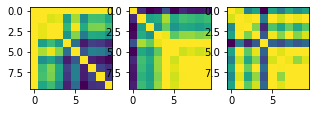

In [10]:
rank = 3
W,H = freq_results[rank]['factors'][0]
print(W.shape,H.shape)
HH = H.reshape(rank,10,10)
f,ax = plt.subplots(1,3,figsize=[5,15])
for r in range(rank):
    _H = HH[r,:,:]
    _H[np.diag_indices_from(_H)]=1
#     f,ax = plt.subplots()
    ax[r].imshow(_H,vmax=np.percentile(_H,70))
f.savefig("D:\\Morph_Results\\figures\\NMF\\freq_factors.pdf",format="pdf")